In [9]:
import numpy as np
import librosa
import librosa.display
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd

# My modules
import paths

plt.rcParams['figure.figsize'] = (14, 5)

In [10]:
music_path = os.path.join(os.environ['MUSIC_PATH'])

y, sr = librosa.load(music_path, sr=None) # sr=None preserves the original sample rate
print (sr)
print (len(y))

16000
185856


In [11]:
ipd.Audio(y, rate=sr)

(1025, 581)


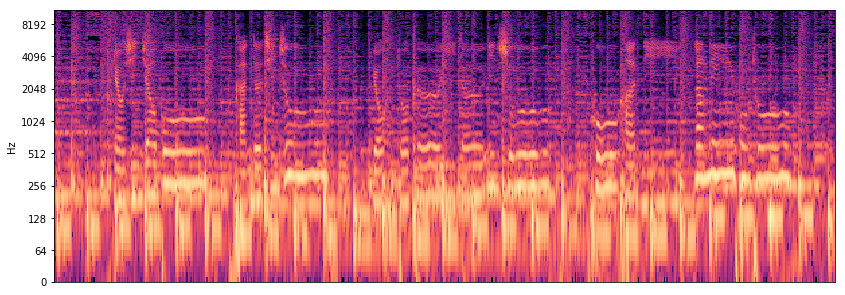

In [12]:
S = librosa.stft(y, win_length=int(40*sr/1000), hop_length=int(20*sr/1000))
D = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(D, y_axis='log')

print (D.shape)

(579,)


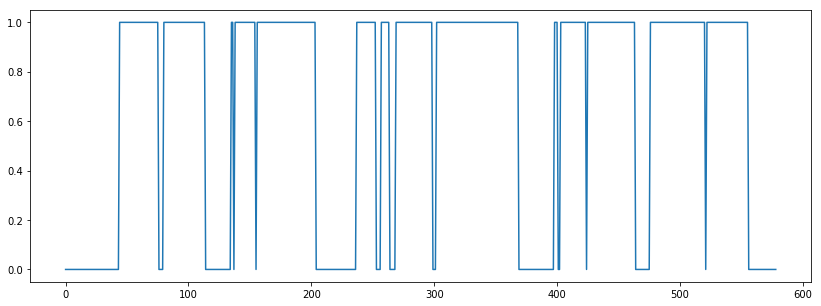

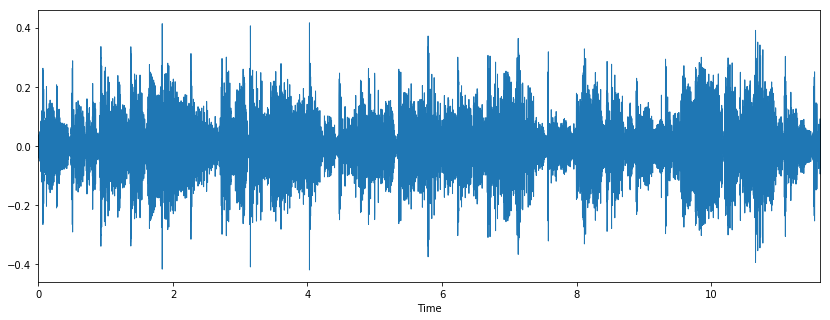

In [13]:
vocal_path = os.path.join(os.environ['VOCAL_PATH'])

label = pd.read_csv(vocal_path, index_col=None, header=None)
label  = np.array(label).reshape((label.shape[0],)).astype('bool')

print (label.shape)
plt.plot(label)
plt.show()

librosa.display.waveplot(y, sr)

# Calculate the energy for each frame using a square window 'w'
Formula: $\sum_m |x(m)w(m-n)|^2 $

The goal to use the energy is capture the voice (when it is have more energy).

In [43]:
# w(x) = 1, for all x

# Samples
hop_length   = int(sr*20/1000) # 20 milisseconds
frame_length = int(sr*40/1000) # 40 milisseconds

energy = np.array([
    sum(abs(y[i:i+frame_length]**2))
    for i in range(0, len(y), hop_length)
])

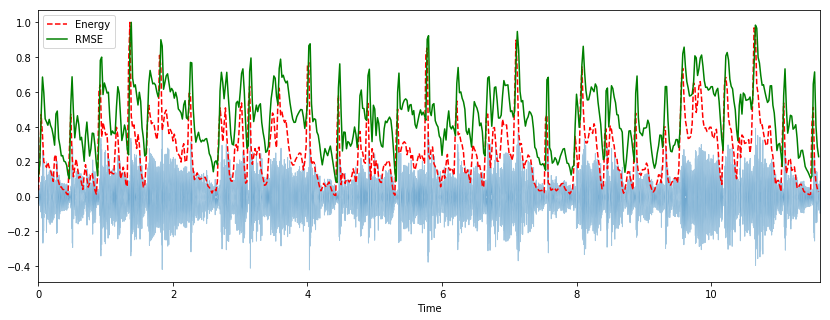

In [44]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))

# Evaluation

In [39]:
import mir_eval

In [32]:
def find_threshold(ref_values, energy):
    """ Find the best threshold for the data - IS IT RIGHT? """
    last_acc = 0 # Start accuracy
    steps = 1000
    
    R, P, Acc, F1, FA = [],[],[],[],[]
    
    for threshold in range(steps):
        # Apply threshold
        est_values = np.where(energy>(threshold/steps), 1, 0)
        
        # Calculate measures
        TP = (ref_values*est_values).sum()
        FP = ((ref_values == 0)*est_values).sum()
        FN = (ref_values*(est_values == 0)).sum()
        TN = ((ref_values == 0)*(est_values == 0)).sum()
        
        R.append(TP/(TP+FN))
        P.append(TP/(TP+FP))
        
        Acc.append((TP+TN)/(TP+TN+FP+FN))
        F1.append(2*P[-1]*R[-1]/(P[-1]+R[-1]))
        FA.append(FP/(FP+TN))
        
        # Verify best values
        if last_acc <= Acc[-1]:
            last_acc = Acc[-1]
            best = (threshold/steps)
            output = est_values

    # Plot measures     
    plt.plot(P, label='P')
    plt.plot(R, label='R')
    plt.plot(F1, label='F1')
    plt.plot(FA, label='FA')
    plt.plot(Acc, label='Acc')
    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
        
    return best, output

Recall 0.873417721519 False Alarme 0.369565217391
Find threshold using Energy


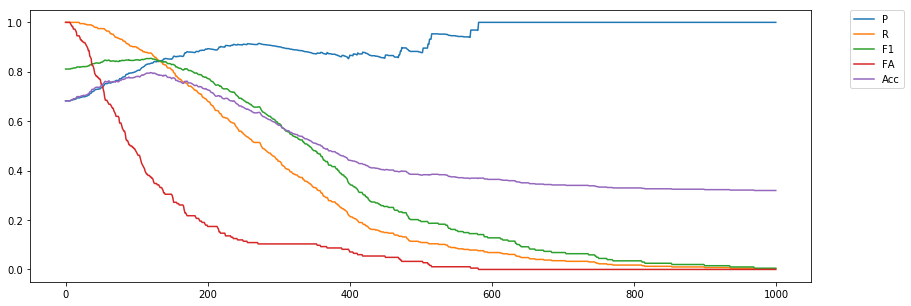

Best threshold: 0.121


In [56]:
R, FA = mir_eval.melody.voicing_measures(label, output) 
print ("Recall", R, "False Alarme", FA)

print("Find threshold using Energy")
threshold, output = find_threshold(label, energy[1:-1]/np.max(energy))
print ("Best threshold:", threshold)

Recall 0.873417721519 False Alarme 0.369565217391
Find threshold using RMSE


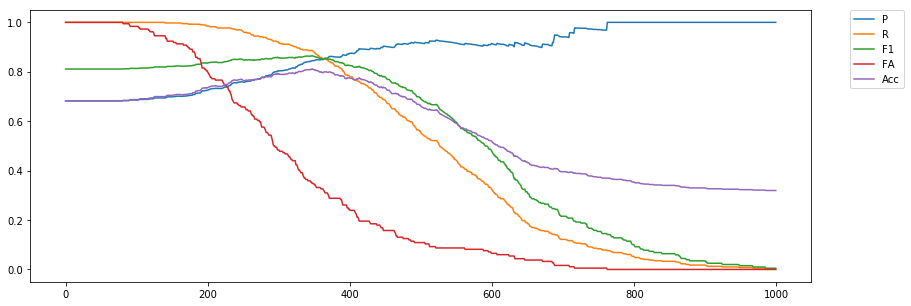

Best threshold: 0.347


In [57]:
R, FA = mir_eval.melody.voicing_measures(label, output) 
print ("Recall", R, "False Alarme", FA)

print("Find threshold using RMSE")
threshold, output = find_threshold(label, rmse[1:-1]/np.max(rmse))
print ("Best threshold:", threshold)

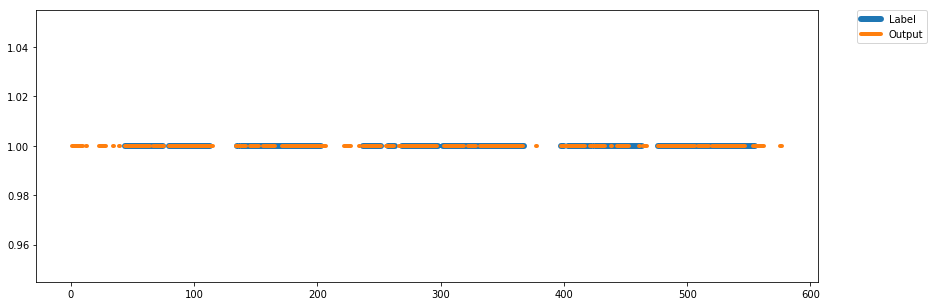

In [58]:
lbl = np.where(label>0, 1, None)

out = np.where(output>0, 1, None)

plt.plot(lbl, label="Label", lw=6.0, solid_capstyle='round')
plt.plot(out, label="Output", lw=4.0, solid_capstyle='round')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

I think it works for this dataset because the singing voice is louder then the accompaniment. When the singer starts to sing, the energy increase on signal.

In [47]:
from sklearn.metrics import roc_auc_score, auc

roc_auc = roc_auc_score(label, output)
roc_auc

0.75192625206384145